In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2],
    c2 = [0.5, 2],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = None,
    mask = None))

see one see two 2 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 2
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c1 = np.max([model.optimizer.C1[1] - ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[0]])
    model.optimizer.c2 = np.min([model.optimizer.C2[0] + ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 100, Accuracy: 0.8580246913580247, Loss: 0.5813415668628834
Checkpoint 200, Accuracy: 0.8641975308641975, Loss: 0.5700088783546731
Checkpoint 300, Accuracy: 0.8580246913580247, Loss: 0.567316867687084
Checkpoint 400, Accuracy: 0.8580246913580247, Loss: 0.5710746270638926
Checkpoint 500, Accuracy: 0.8580246913580247, Loss: 0.5639426619918259


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [[0.7418237 ]
 [0.14749528]
 [0.11068103]]
[0. 1. 0.] <-> [[0.06352127]
 [0.51538044]
 [0.42109832]]
[0. 0. 1.] <-> [[0.00243599]
 [0.15323186]
 [0.84433216]]
[1. 0. 0.] <-> [[0.83686113]
 [0.09125703]
 [0.07188186]]
[0. 0. 1.] <-> [[0.88961804]
 [0.06102028]
 [0.04936159]]
[1. 0. 0.] <-> [[0.94134736]
 [0.03224218]
 [0.02641049]]
[1. 0. 0.] <-> [[0.7838855 ]
 [0.12235729]
 [0.09375725]]
[1. 0. 0.] <-> [[0.8142089 ]
 [0.10447289]
 [0.08131823]]
[0. 0. 1.] <-> [[0.7904791 ]
 [0.11845054]
 [0.09107026]]
[1. 0. 0.] <-> [[0.563775  ]
 [0.25727853]
 [0.17894648]]
[1. 0. 0.] <-> [[0.92593694]
 [0.0407153 ]
 [0.03334781]]
[0. 1. 0.] <-> [[0.1386486 ]
 [0.51380825]
 [0.34754315]]
[0. 0. 1.] <-> [[0.17518738]
 [0.49739835]
 [0.32741427]]
[1. 0. 0.] <-> [[0.87800205]
 [0.06760714]
 [0.05439083]]
[1. 0. 0.] <-> [[0.9283006 ]
 [0.03940998]
 [0.03228946]]
[0. 0. 1.] <-> [[0.9450117 ]
 [0.03024039]
 [0.02474788]]
[1. 0. 0.] <-> [[0.8290002 ]
 [0.09582857]
 [0.07517124]]
[1. 0. 0.] <->

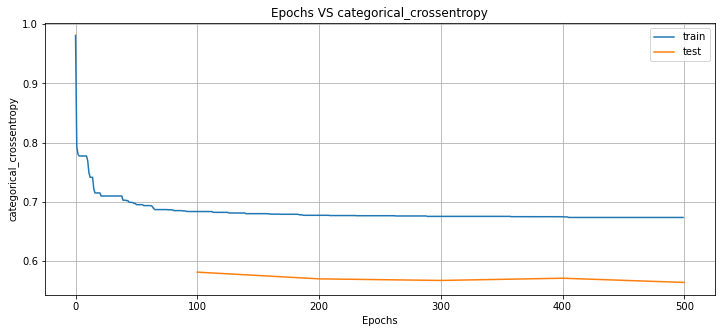

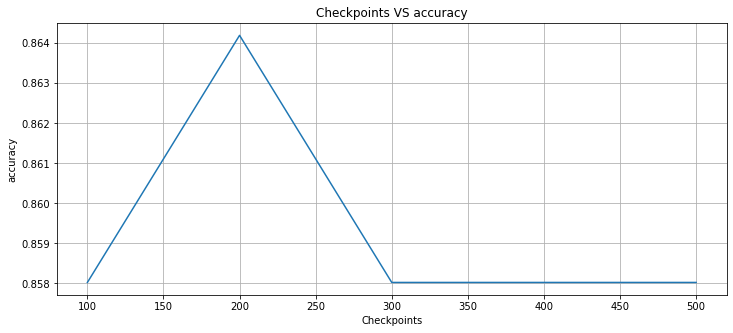

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8580246913580247, 'mean_square_error': 2.7696725004807483, 'categorical_crossentropy': 0.5813415668628834, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 12, 'tn_hit': 16, 'fn_hit': 4}, 1: {'tp_hit': 2, 'fp_hit': 7, 'tn_hit': 86, 'fn_hit': 13}, 2: {'tp_hit': 7, 'fp_hit': 4, 'tn_hit': 91, 'fn_hit': 6}}, 'checkpoint': 100} 


{'accuracy': 0.8641975308641975, 'mean_square_error': 2.841947040017413, 'categorical_crossentropy': 0.5700088783546731, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 12, 'tn_hit': 16, 'fn_hit': 4}, 1: {'tp_hit': 3, 'fp_hit': 7, 'tn_hit': 86, 'fn_hit': 12}, 2: {'tp_hit': 7, 'fp_hit': 3, 'tn_hit': 92, 'fn_hit': 6}}, 'checkpoint': 200} 


{'accuracy': 0.8580246913580247, 'mean_square_error': 2.8805043966908244, 'categorical_crossentropy': 0.567316867687084, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 12, 'tn_hit': 16, 'fn_hit': 4}, 1: {'tp_hit': 4, 'fp_hit': 9, 'tn_hit': 84, 'fn_hit': 11}, 2: {'tp_hit': 5, 'fp_hit': 2, 'tn_hit': 93, 'fn_hit

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[[-1.0000354 ]
 [ 1.4459995 ]
 [ 0.64534944]
 [-0.95799637]
 [ 0.88535416]]
 bias: [-0.82791936]

Neuron 1: weights:
[[ 1.2303635 ]
 [ 0.3422954 ]
 [-0.81347066]
 [ 0.12074991]
 [-0.2680288 ]]
 bias: [-2.7111626]

Neuron 2: weights:
[[-0.03702106]
 [ 0.7376266 ]
 [-0.90794754]
 [-0.334455  ]
 [ 1.1636778 ]]
 bias: [-1.1756998]

Neuron 3: weights:
[[ 0.5024761]
 [-1.2462065]
 [-1.0749599]
 [ 0.1310116]
 [ 1.056876 ]]
 bias: [-0.13780692]

$
Layer 2
Neuron 0: weights:
[[-2.1446342 ]
 [-3.        ]
 [ 0.38981873]
 [ 2.063231  ]]
 bias: [0.565946]

Neuron 1: weights:
[[ 0.29276937]
 [-1.5379484 ]
 [ 2.143489  ]
 [-0.6705798 ]]
 bias: [-0.7743813]

Neuron 2: weights:
[[-0.9227155]
 [ 1.5562341]
 [ 2.4005926]
 [-0.7437812]]
 bias: [-0.93383974]

$

